# Indeed job listing data - Exploratory Data Analysis (EDA) 

In [1]:
# Install necessary packages 
#!pip install missingno
#!pip install wordcloud

In [2]:
# Import necessary packages 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from collections import defaultdict

%matplotlib inline

## Load the data
Import the data scraped using scraper-countries.py (Sept 20-21 2024), for the following countries: USA, Sweden, France, and Italy. These datasets contain the job listings for the 3 largest cities in respective country, for the job titles _Data Scientist_, _Data Analyst_, _Product Analyst_, and _BI Analyst_.

In [3]:
# Import csv files with scraped data for resp. country 
# Sweden 
df_SWE = pd.read_csv('output/indeed_jobs_Sweden.csv')
# France 
df_FRA = pd.read_csv('output/indeed_jobs_France.csv')
# Italy
df_ITA = pd.read_csv('output/indeed_jobs_Italy.csv')

In [4]:
# USA 
def merge_cities(cities):
    df_NY = pd.read_csv(f'{'output/indeed_jobs_USA_'}{cities[0]}{'.csv'}')
    # df_NY has no country column, add it manually to match the format of the other US cities
    df_NY['country'] = 'USA'
    df_LA = pd.read_csv(f'{'output/indeed_jobs_USA_'}{cities[1]}{'.csv'}')
    df_CHI = pd.read_csv(f'{'output/indeed_jobs_USA_'}{cities[2]}{'.csv'}')
    # Make sure order of columns is the same as for LA and Chicago
    desired_order = df_LA.columns.tolist()
    print('Order of columns: ', desired_order)
    df_NY = df_NY[desired_order]
    # Concactenate rows for US cities 
    df_USA = pd.concat([df_NY, df_LA, df_CHI], ignore_index=True)
    # Verify that it worked 
    df_USA.columns.tolist()==desired_order
    return(df_USA)

df_USA = merge_cities(['NY', 'LA', 'CHI'])

Order of columns:  ['page', 'country', 'job_link', 'search_keyword', 'search_location', 'job_title', 'company_name', 'company_location', 'salary', 'job_description']


## Initial inspection of the data

In [5]:
df_SWE.head(5)
#df_SWE.tail(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,Not available,Data Analyst (Data Visualization) \n \n Swediu...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data+Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,Not available,Role: \n \n Website Performance: Web analyst f...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data+Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities \n \n Website Performance: W...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description \n Statistics show that w...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data+Analyst,Stockholm,"Juniora Analysts till Operations, Engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning \n \n \n Deloitte är en g...


In [6]:
df_FRA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [7]:
df_ITA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Business Intelligence (Power BI) - Python- Bus...,Area IT Group,"Roma, Lazio",25.000 € - 40.000 € all'anno,Ricerchiamo Sviluppatori in almeno uno dei seg...
1,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Power Bi Analyst,Verisure Italy,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
2,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",IT Project Management Internship,Procter & Gamble,"Roma, Lazio",Not available,Job Location Rome Job Description INFORMATI...
3,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Credit & Collection Data Analyst,Verisure Italy S R L,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
4,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Aeronautical System Analyst,adecco,"Roma, Lazio",Not available,Per azienda leader a livello globale nella ges...


In [8]:
df_USA.head(5)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Business Analyst (Data products),Aon,"Remote in New York, NY","$80,000 - $95,000 a year - Full-time","Senior Associate Consultant, Data Solutions ..."
1,1,USA,https://www.indeed.com/rc/clk?jk=6b99bd10f1316...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone,"New York, NY",$32.38 - $39.01 an hour - Temporary,NYU Grossman School of Medicine is one of the...
2,1,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone Health,"New York, NY 10016","$67,771.14 - $75,000.00 a year - Full-time",NYU Grossman School of Medicine is one of the...
3,1,USA,https://www.indeed.com/rc/clk?jk=3aa26222eadd6...,Data+Analyst,"New+York, NY","Resy Marketing Data Analyst, Data and Analytics",Amex,"Hybrid work in New York, NY","$60,000 - $110,000 a year",You Lead the Way. We’ve Got Your Back. \n With...
4,1,USA,https://www.indeed.com/rc/clk?jk=3aa564ce173c8...,Data+Analyst,"New+York, NY",2025 University Graduate - Digital Strategy An...,Adobe,"New York, NY 10012","$53,900 - $101,450 a year - Full-time",Our Company Changing the world through digit...


### Check dimensions and data types

In [9]:
# Check dimensions of dfs 
print(f'SWE \t   columns: {df_SWE.shape[1]} \t  rows: {df_SWE.shape[0]}')
print(f'FRA \t   columns: {df_FRA.shape[1]} \t  rows: {df_FRA.shape[0]}')
print(f'ITA \t   columns: {df_ITA.shape[1]} \t  rows: {df_ITA.shape[0]}')
print(f'USA \t   columns: {df_USA.shape[1]} \t  rows: {df_USA.shape[0]}')

SWE 	   columns: 10 	  rows: 320
FRA 	   columns: 10 	  rows: 2200
ITA 	   columns: 10 	  rows: 769
USA 	   columns: 10 	  rows: 1317


In [10]:
# Check data types
df_SWE.info() 
# Most columns are of type 'Dtype object'
# Convert columns with strings only to string data type to optimize performance
# Mixed columns with both numbers and strings: company_location, salary, job_link (url) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   page              320 non-null    int64 
 1   country           320 non-null    object
 2   job_link          320 non-null    object
 3   search_keyword    320 non-null    object
 4   search_location   320 non-null    object
 5   job_title         320 non-null    object
 6   company_name      320 non-null    object
 7   company_location  320 non-null    object
 8   salary            320 non-null    object
 9   job_description   320 non-null    object
dtypes: int64(1), object(9)
memory usage: 25.1+ KB


In [11]:
# Dictionary specifying column names and desired data types
dtype_dict = {
    'page': 'int64',  
    'country': 'string', 
    'job_link': 'object', 
    'search_keyword': 'string', 
    'search_location': 'string', 
    'job_title': 'string', 
    'company_name': 'string', 
    'company_location': 'object', 
    'salary': 'object', 
    'job_description': 'string'
}

# Convert objects to strings 
df_SWE = df_SWE.astype(dtype_dict)

# Output new data types
print(df_SWE.dtypes) # Is string[python] not dtype string?

page                         int64
country             string[python]
job_link                    object
search_keyword      string[python]
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [12]:
# Do the same for the other datasets 
df_FRA = df_FRA.astype(dtype_dict)
df_ITA = df_ITA.astype(dtype_dict)
df_USA = df_USA.astype(dtype_dict)

## Some descriptive statistics

In [13]:
# Describe (numerical) columns  
df_SWE.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,320.000000,320,320,320,320,320,320,320,320,320
unique,NaN,1,320,4,3,198,198,88,11,263
top,NaN,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Scientist,Stockholm,Data Analyst,Volvo Group,Stockholm,Not available,Who is Infinitas Learning? \n For everyone who...
freq,NaN,320,1,144,225,22,9,87,183,4
mean,2.453125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.734128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def desc_categorical(data):
    # Get frequency counts for each categorical column
    string_columns = data.select_dtypes(include='string').drop(columns='job_description') # Skip job description! 
    # Get frequency counts for the categorical columns with mixed data types (strings and numbers)
    object_columns = data.select_dtypes(include='object').drop(columns='job_link')

    # Loop through the columns and print value counts
    for col in string_columns.columns:
        print(f'Value counts for column: {col}\n{string_columns[col].value_counts()}\n')
    for col in object_columns.columns:
        print(f'Value counts for column: {col}\n{object_columns[col].value_counts()}\n')

desc_categorical(df_SWE) 

Value counts for column: country
country
Sweden    320
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Scientist     144
Product+Analyst    100
BI+Analyst          41
Data+Analyst        35
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Stockholm    225
Göteborg      72
Malmö         23
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Analyst                                           22
Systemutvecklare                                       20
Data Scientist                                         15
Business Analyst                                       10
Senior Data Scientist                                   6
                                                       ..
Senior Logistics Analyst                                1
Senior PIM Consultant                                   1
Analyst Relations and Market Intelligence Manager       1
Senior Principal Product Analyst | Candy C

### Preliminary observations, Swedish job listings:
- __Most frequent job titles__: Data Analyst, systemutvecklare, Data Scientist.
- __Most frequent company__: Volvo Group. 
- __Salary ranges__: Few numerical values are provided.

In [15]:
df_FRA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,2200.000000,2200,2200,2200,2200,2200,2200,2200,2200,2200
unique,NaN,1,2200,4,3,1213,718,256,165,1311
top,NaN,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),Data Analyst H/F,AXA,Paris (75),Temps plein,Not available
freq,NaN,2200,1,757,1949,34,64,582,512,51
mean,17.454091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13.220097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
desc_categorical(df_FRA) 

Value counts for column: country
country
France    2200
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Analyst       757
Product+Analyst    662
BI+Analyst         463
Data+Scientist     318
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Paris (75)        1949
Lyon (69)          210
Marseille (13)      41
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Analyst H/F                                                   34
Data Analyst                                                       19
Data Analyst (F/H)                                                 18
Data Analyst Intern                                                17
Senior Product Data Analyst                                        13
                                                                   ..
Treasury Senior Analyst - Expert                                    1
Ingénieur systèmes Windows - secteur de l'assurance H/F

### Preliminary observations, French job listings:
- Many listings compared to Sweden. 
- __Most frequent job titles__: Data Analyst H/F (many similar names for this title, e.g. Data Analyst, Data Analyst F/H). 
- __Most frequently mentioned company__: AXA.
- __Company location__: Includes some information about télétravail (especially common in Paris).  
- __Salary ranges__: Need to split column to be able to draw any conclusions.

In [17]:
df_ITA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,769.000000,769,769,769,769,769,769,769,769,769
unique,NaN,1,769,4,3,469,309,96,15,554
top,NaN,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Milano, Lombardia",Data Scientist,BIP - Business Integration Partners,"Milano, Lombardia",Not available,Company: TELEPASS ASSICURA\n \n \n \n \n ...
freq,NaN,769,1,419,540,32,39,207,746,5
mean,5.954486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.317205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
desc_categorical(df_ITA) 

Value counts for column: country
country
Italy    769
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Analyst       419
Data+Scientist     170
Product+Analyst     90
BI+Analyst          90
Name: count, dtype: Int64

Value counts for column: search_location
search_location
Milano, Lombardia    540
Roma, Lazio          203
Napoli, Campania      26
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Scientist                                              32
Data Analyst                                                23
Business Analyst                                            14
Senior Data Analyst                                         10
Pricing Analyst                                              5
                                                            ..
BUSINESS ANALYST - BI                                        1
BI Analyst                                                   1
Process Analyst                      

### Preliminary observations, Italian job listings:
- Many listings compared to Sweden, but less than France.
- __Most frequent job titles__: Data Analyst, Data Scientist, Product Analyst. 
- __Most frequently mentioned company__: BIP - Business Integration Partners. 
- __Company location__: Milano. Also remote in Milano is relatively common (as is Rome).
- __Salary ranges__: Very few numerical entries provided. 

In [19]:
df_USA.describe(include='all')

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,1317.000000,1317,1317,1317,1317,1317,1317,1317,1317,1317
unique,NaN,1,1317,4,3,739,470,185,525,823
top,NaN,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Data Analyst,Citi,"New York, NY",Full-time,"Guy Carpenter & Company, LLC is seeking candid..."
freq,NaN,1317,1,522,771,29,44,269,236,6
mean,6.425968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.684258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
desc_categorical(df_USA) 

Value counts for column: country
country
USA    1317
Name: count, dtype: Int64

Value counts for column: search_keyword
search_keyword
Data+Analyst       522
Data+Scientist     396
BI+Analyst         315
Product+Analyst     84
Name: count, dtype: Int64

Value counts for column: search_location
search_location
New+York, NY       771
Chicago, IL        444
Los+Angeles, CA    102
Name: count, dtype: Int64

Value counts for column: job_title
job_title
Data Analyst                                                  29
Business Analyst                                              25
Senior Business Analyst                                       19
Senior Machine Learning Engineer                              13
Senior Data Analyst                                           11
                                                              ..
Analyst - Innovation and Solutions III                         1
Analyst, Commerce                                              1
Product Owner – Digital Medi

### Preliminary observations, American job listings:
- Number of listings are less than for France. 
- __Most frequent job titles__: Data Analyst, Data Scientist, BI analyst. 
- __Most frequently mentioned company__: Citi. 
- __Company location__: New York.  
- __Salary ranges__: Need to split column to draw conclusions. 

### Conclusions
- The following columns needs to be cleaned: search_keyword, job_title, job_description, company_location.   
- The salary column should be split into two columns (separate numeric vs string content).    
- Job titles appear to vary somewhat between countries (since top 3 ones were different for different countries). 


## Data reduction and data cleaning
Handle missing and duplicate data entries. Remove unnecessary columns (if any). 
Clean and preprocess the data to handle anomalies and outliers. 

### Missing values

In [21]:
# Handle missing values 
# The scraper labels cells as 'Not available' when there is no value. Change these to NaN. 
# Replace 'Not available' with NaN
df_SWE.replace('Not available', np.NaN, inplace=True)
df_FRA.replace('Not available', np.NaN, inplace=True) 
df_ITA.replace('Not available', np.NaN, inplace=True)
df_USA.replace('Not available', np.NaN, inplace=True)

df_FRA.isnull().sum() # Missing salary and job description entries 
df_SWE.isnull().sum() # Missing salary entries 
df_ITA.isnull().sum() # Missing salary entries 
df_USA.isnull().sum() # Missing salary entries 

# Also calculate percentage of missing values
df_FRA.isnull().mean() * 100

# Salary entries will be handled later when columns are split 
# For now we do not drop these rows (we are not primarily interested in salaries)

page                 0.000000
country              0.000000
job_link             0.000000
search_keyword       0.000000
search_location      0.000000
job_title            0.000000
company_name         0.000000
company_location     0.000000
salary              17.181818
job_description      2.318182
dtype: float64

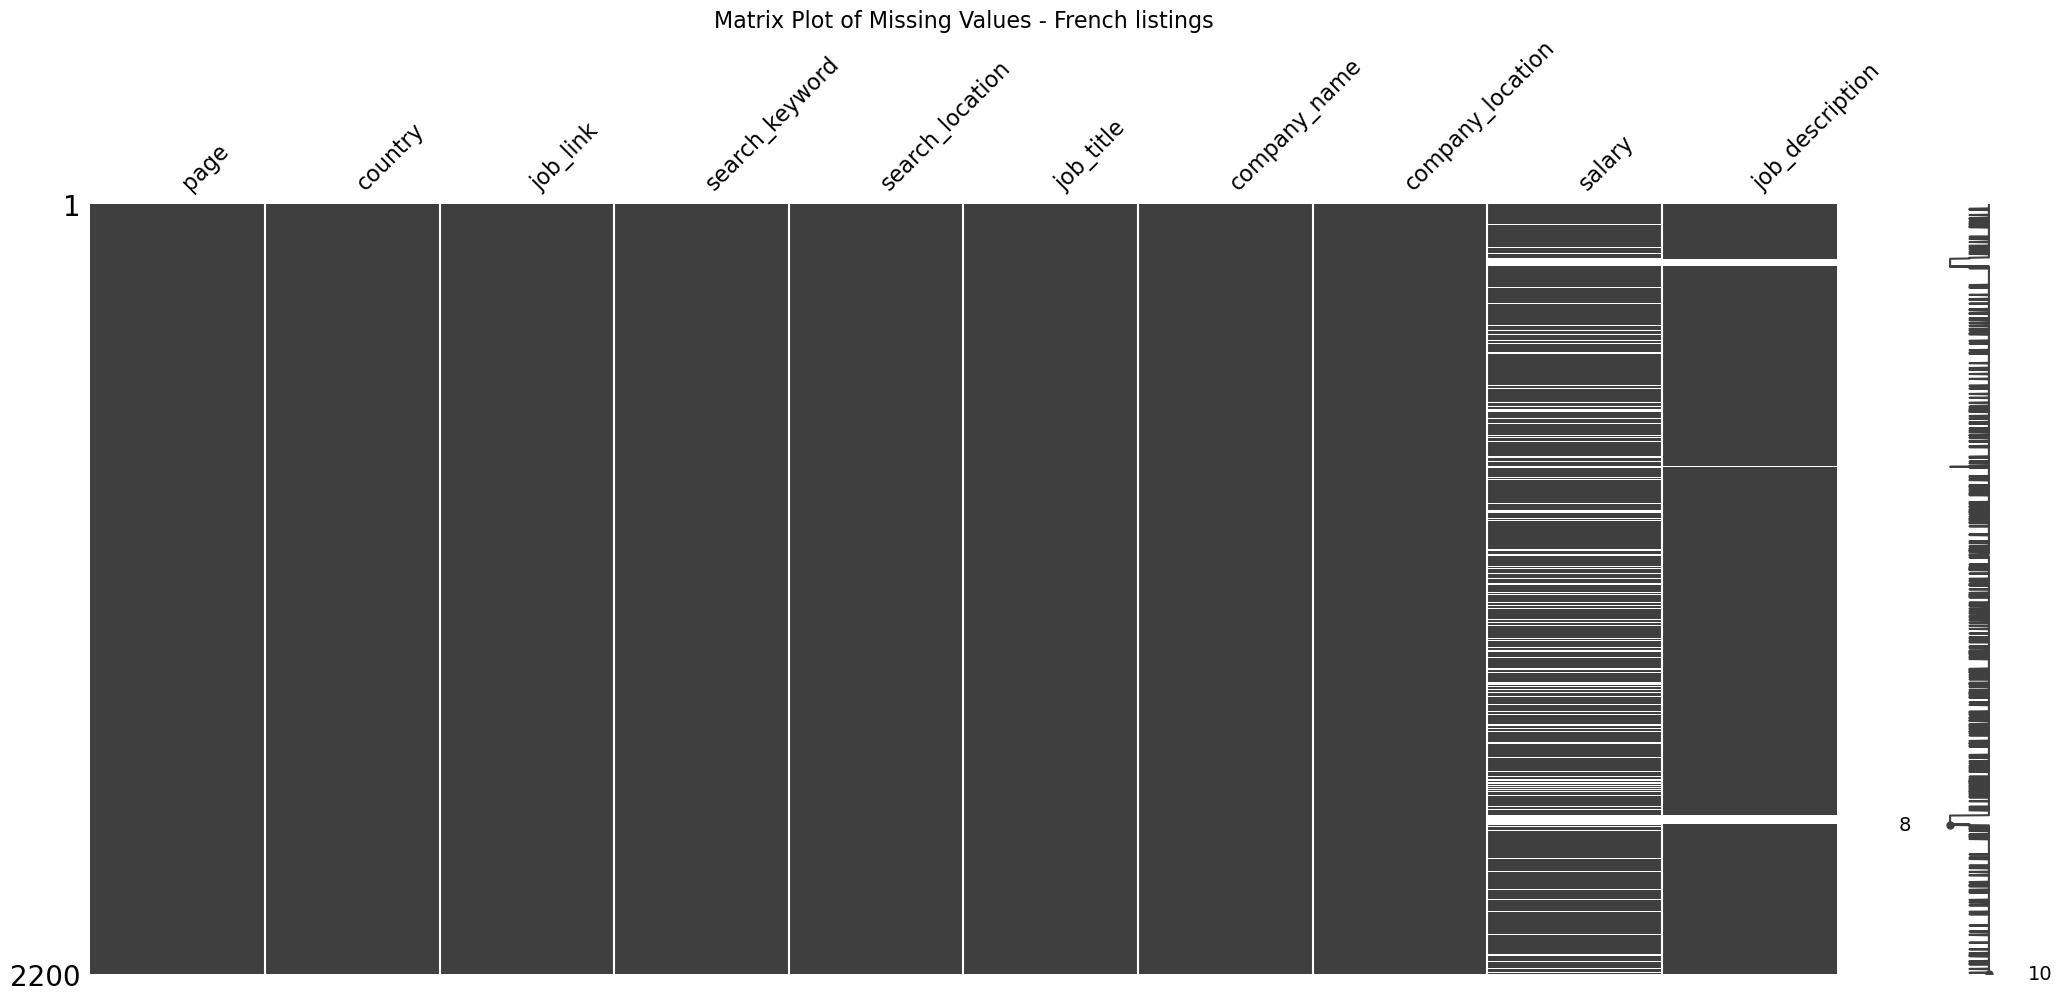

In [22]:
# Visualize missing data patterns using missingno
msno.matrix(df_FRA) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  # Add a title to the plot
plt.show()

In [23]:
# Look into the missing descriptions for French job listings (seems that request was blocked)
print(df_FRA.isnull().sum())
#df_FRA[df_FRA['job_description'].isnull()]

# Manual imports of missing job descriptions from URLs 
df_FRA_missing = pd.read_csv('df_FRA_missing_data.csv')

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64


In [24]:
# Merge the DataFrames based on the 'job_link' column
merged_df = pd.merge(df_FRA, df_FRA_missing, on=['job_link'])
merged_df = pd.merge(df_FRA, df_FRA_missing[['job_link', 'job_description_new']], on='job_link', how='left')
# Save the job description as only one column (based on when it is not NaN)
merged_df['job_description'] = merged_df['job_description'].combine_first(merged_df['job_description_new'])
merged_df.drop('job_description_new', axis=1, inplace=True)
# Verify that there are no missing values in job_description now
merged_df

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...
...,...,...,...,...,...,...,...,...,...,...
2195,3,France,https://www.indeed.fr/rc/clk?jk=e140c6dba19957...,BI+Analyst,Lyon (69),COMMERCIAL PERFORMANCE DATA OWNER H/F,Groupe Seb,Écully (69),NaN,Minimum annual compensation (individual bonuse...
2196,4,France,https://www.indeed.fr/rc/clk?jk=02f3391fc923b2...,BI+Analyst,Lyon (69),Consultant en Gestion et Gouvernance de l'info...,Eowin,Lyon (69),"CDI, Temps plein",Fort de plus de 30 ans d’expérience dans la ge...
2197,4,France,https://www.indeed.fr/rc/clk?jk=9761f99e5e5999...,BI+Analyst,Lyon (69),DevOps (H/F),Askills,Lyon (69),"CDI, Temps plein",Askills est un jeune cabinet de conseil lyonna...
2198,4,France,https://www.indeed.fr/rc/clk?jk=76d98e1171c985...,BI+Analyst,Lyon (69),Tech Lead H/F,Sogeti,Lyon (69),CDI,Description de l'entreprise \n \n \n SOGETI c'...


In [25]:
merged_df.isnull().sum()
df_FRA = merged_df

In [26]:
print(df_FRA.isnull().sum())

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64


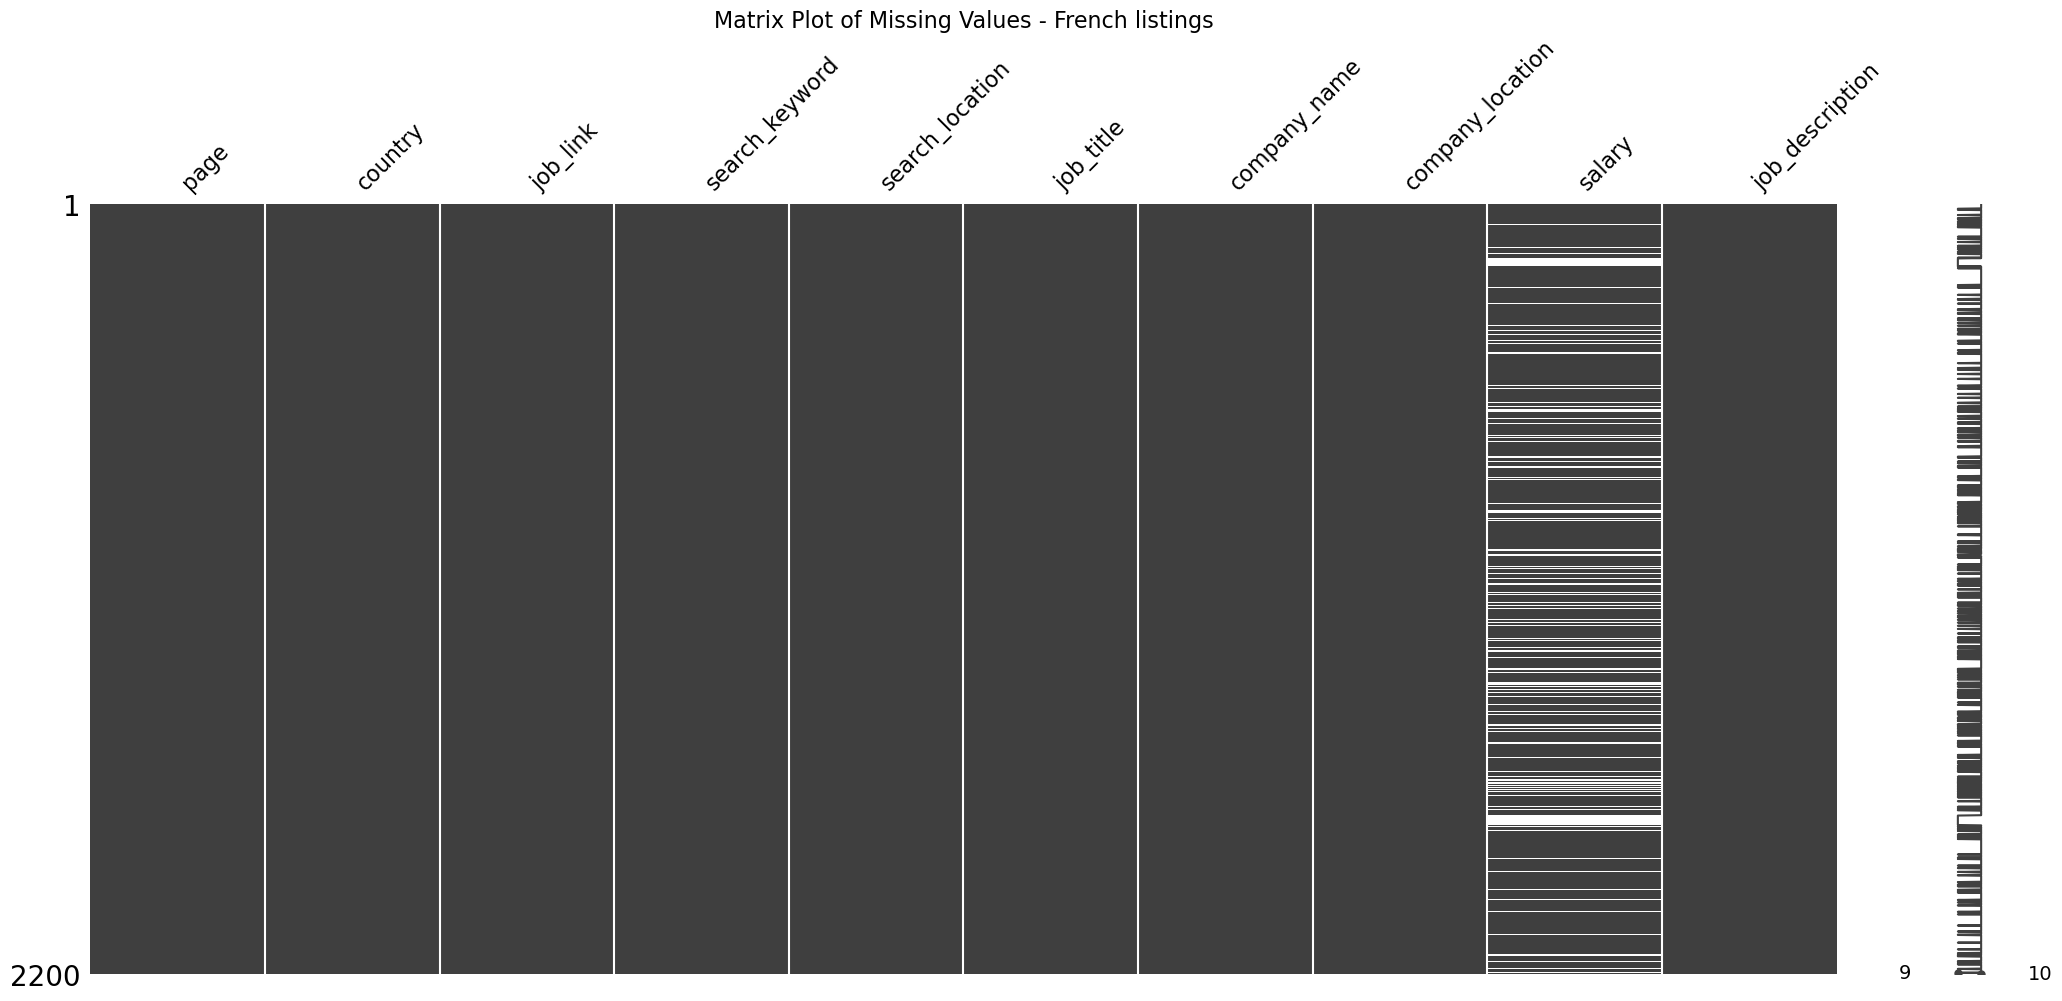

In [27]:
# Now the job_description should not have missing values anymore
msno.matrix(df_FRA) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  
plt.show()

In [28]:
df_FRA[df_FRA['salary'].isnull()]

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
13,1,France,https://www.indeed.fr/rc/clk?jk=deaa67e6674535...,Data+Analyst,Paris (75),Data Analyste pour Ubigi H/F,Transatel,Télétravail partiel à 92800 Puteaux,NaN,Transatel est un fournisseur mondial de soluti...
14,1,France,https://www.indeed.fr/rc/clk?jk=f0889f8fa3f283...,Data+Analyst,Paris (75),Data Analyst (F/H),Novencia,Paris (75),NaN,Carnet de route \n \n Novencia accompagne ses ...
16,2,France,https://www.indeed.fr/rc/clk?jk=deaa67e6674535...,Data+Analyst,Paris (75),Data Analyste pour Ubigi H/F,Transatel,Télétravail partiel à 92800 Puteaux,NaN,Transatel est un fournisseur mondial de soluti...
31,3,France,https://www.indeed.fr/rc/clk?jk=fd64421c261c1f...,Data+Analyst,Paris (75),Data-Analyst Audit- H/F/X,Société Générale,La Défense (92),NaN,Vos missions au quotidien \n \n \n Vous savez ...
40,3,France,https://www.indeed.fr/rc/clk?jk=4ad068c42c765d...,Data+Analyst,Paris (75),Global Market Data Analyst,URGO,Paris (75),NaN,Paris\n \n \n \n \n \n \n \n \n \n \n \...
...,...,...,...,...,...,...,...,...,...,...
2164,1,France,https://www.indeed.fr/rc/clk?jk=03d3354cf0feb3...,BI+Analyst,Lyon (69),Global Business Process Analyst,Louis Dreyfus Company,Villeurbanne (69),NaN,Company Description\n \n \n \n Louis Dreyf...
2169,2,France,https://www.indeed.fr/rc/clk?jk=627eb7b9017ddf...,BI+Analyst,Lyon (69),Data Analyst F/H,Visiativ,Télétravail partiel à 69002 Lyon,NaN,"Chez ABGi, filiale de Visiativ, nous avons la ..."
2171,2,France,https://www.indeed.fr/rc/clk?jk=5aab0c64b77111...,BI+Analyst,Lyon (69),Consultant Projet BI et Big Data (F/H),Novencia,Lyon (69),NaN,Carnet de route \n \n Chef de projet BI / Big ...
2184,3,France,https://www.indeed.fr/rc/clk?jk=2a3415f06aecdb...,BI+Analyst,Lyon (69),Consultant décisionnel BI (H/F),Insitoo,Lyon (69),NaN,"Basée à Lille, Lyon, Nantes, Grenoble et Bruxe..."


### Check for duplicates

In [29]:
# Check for potential duplicates 
# unique() prints the unique values, nunique() prints the number of unique values

def check_duplicates(data):
    # The number of rows should be equal to the number of unique job links, etc 
    # Get the number of rows 
    num_rows = data.shape[0]
    # Print the number of rows
    print(f'The DataFrame has {num_rows} rows.')
    print(data.nunique()) 
    # Check for duplicates in all columns
    duplicates = data.duplicated(keep=False)
    # Print duplicate rows 
    print(data[duplicates])

check_duplicates(df_FRA)

The DataFrame has 2200 rows.
page                  47
country                1
job_link            2200
search_keyword         4
search_location        3
job_title           1213
company_name         718
company_location     256
salary               164
job_description     1355
dtype: int64
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []


__Conclusion:__ There seem to be no issues with duplicated entries. 

In [30]:
df_FRA.isnull().sum()

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64

### Retrieve numeric values for salary

In [31]:
# Format, clean, and fix columns 

# Salary conversion function to handle both thousand separators and decimal points
def convert_salary(value):
    # Converts salary strings with thousand separators or decimal points into a float.
    return float(value.replace('\xa0', '').replace(' ', '').replace(',', '').replace('.', '').replace('..', '.'))

def clean_columns(data):
    # Remove + signs and replace them with spaces in 'search_keyword' and 'search_location'
    data[['search_keyword', 'search_location']] = data[['search_keyword', 'search_location']].replace({r'\+': ' '}, regex=True)
    
    # Remove all newline characters from 'job_description'
    data['job_description'] = data['job_description'].replace({r'\n': ' '}, regex=True)
    
    # Extract salary numbers using regex
    # This regex captures numbers with commas, spaces, and periods, handling both American and European formats
    data['salary'] = data['salary'].astype(str)
    data['salary_num'] = data['salary'].apply(lambda x: re.findall(r'\d{1,3}(?:[,\s]\d{3})*(?:\.\d+)?', x))
    
    # Replace empty lists with NaN in 'salary_num'
    data['salary_num'] = data['salary_num'].apply(lambda x: x if x else np.nan)
    
    # Create 'salary_num_low' and 'salary_num_high' by extracting and cleaning the numbers
    # If there is only one number put it in both low and high column
    data['salary_num_low'] = data['salary_num'].apply(lambda x: convert_salary(x[0]) if isinstance(x, list) and len(x) > 0 else np.nan)
    data['salary_num_high'] = data['salary_num'].apply(lambda x: convert_salary(x[0]) if isinstance(x, list) and len(x) == 1 else convert_salary(x[1]) if isinstance(x, list) and len(x) > 1 else np.nan)

    # Extract time period from 'salary' column using regex
    # par an since 'an' is an English word 
    data['time_period'] = data['salary'].str.extract(r'(hour|year|month|week|day|ora|anno|mese|settimana|giorno|heure|par an|mois|semaine|jour|månad)')

    return data

## Feature engineering 

In [32]:
'''
# Check if any rows in the 'salary' column contain the word 'day'
has_weekly = df_USA['salary'].str.contains('a day', case=False, na=False).any()

# Output the result
if has_weekly:
    print("There are rows with 'a day' in the salary column.")
else:
    print("No rows with 'a day' in the salary column.")
'''

'\n# Check if any rows in the \'salary\' column contain the word \'day\'\nhas_weekly = df_USA[\'salary\'].str.contains(\'a day\', case=False, na=False).any()\n\n# Output the result\nif has_weekly:\n    print("There are rows with \'a day\' in the salary column.")\nelse:\n    print("No rows with \'a day\' in the salary column.")\n'

In [33]:
def convert_salary_to_monthly(row, salary_column):
    # Dictionary to map time periods (in different languages) to their monthly conversion factor
    time_period_map = {
        'hour': 160, 'ora': 160, 'heure': 160,
        'year': 1/12, 'anno': 1/12, 'par an': 1/12,
        'week': 4, 'settimana': 4, 'semaine': 4,
        'day': 20, 'giorno': 20, 'jour': 20,
        'month': 1, 'mese': 1, 'mois': 1, 'månad': 1
    }
    
    time_period = row['time_period']
    
    # Check if 'time_period' is a valid string and map it to conversion factor, otherwise return NaN
    if isinstance(time_period, str):
        time_period = time_period.lower()
        return row[salary_column] * time_period_map.get(time_period, np.nan)
    
    return np.nan

# Function to apply salary conversion for min and max salary
def apply_salary_conversion(df, currency):
    df['min_salary_month'] = df.apply(lambda row: convert_salary_to_monthly(row, 'salary_num_low'), axis=1)
    df['max_salary_month'] = df.apply(lambda row: convert_salary_to_monthly(row, 'salary_num_high'), axis=1)
    df['currency'] = currency  # Add currency column
    return df

In [34]:
# Create a dictionary of dfs and their corresponding currencies
currency_mapping = {
    'SWE': 'SEK',  # Swedish Krona
    'FRA': 'EUR',  # Euro
    'ITA': 'EUR',  # Euro
    'USA': 'USD'   # US Dollar
}

# Create a dictionary of DataFrames
dfs = {'SWE': df_SWE, 'FRA': df_FRA, 'ITA': df_ITA, 'USA': df_USA}

# Function to clean DataFrames, add a currency column, and calculate salary per month
def clean_and_add_currency_and_salaries(df, currency):
    cleaned_df = clean_columns(df)  # Clean the DataFrame
    cleaned_df['currency'] = currency  # Add currency column
    # Calculate min and max salary per month
    cleaned_df['min_salary_month'] = cleaned_df.apply(lambda row: convert_salary_to_monthly(row, 'salary_num_low'), axis=1)
    cleaned_df['max_salary_month'] = cleaned_df.apply(lambda row: convert_salary_to_monthly(row, 'salary_num_high'), axis=1)
    return cleaned_df

# Loop through the dictionary and apply the function to clean dfs and add currency and salaries
dfs = {key: clean_and_add_currency_and_salaries(df, currency_mapping[key]) for key, df in dfs.items()}


In [35]:
'''
# Unpack the cleaned DataFrames
df_SWE, df_FRA, df_ITA, df_USA = dfs.values()

# Inspect output 
print(df_ITA.isnull().sum())
# Check salary ranges 
df_ITA.describe()
# Filter out data when column 'salary_num' is not NaN
df_filtered = df_ITA.dropna(subset=['salary_num'])
df_filtered
'''

"\n# Unpack the cleaned DataFrames\ndf_SWE, df_FRA, df_ITA, df_USA = dfs.values()\n\n# Inspect output \nprint(df_ITA.isnull().sum())\n# Check salary ranges \ndf_ITA.describe()\n# Filter out data when column 'salary_num' is not NaN\ndf_filtered = df_ITA.dropna(subset=['salary_num'])\ndf_filtered\n"

In [36]:
# Merge all dfs in the dictionary into a single df
df_combined = pd.concat(dfs.values(), ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)

# Add dates when data was scraped 
df_combined['date'] = np.where(df_combined['country'].isin(['Sweden', 'USA']), pd.to_datetime('2024-09-19'), pd.to_datetime('2024-09-20'))
df_combined.describe()

,page,salary_num_low,salary_num_high,min_salary_month,max_salary_month,date
count,4606.000000,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,4606
mean,11.338689,2.794966e+05,4.226127e+05,3.227590e+04,4.621777e+04,2024-09-19 15:28:12.922275328
min,1.000000,6.000000e+00,6.000000e+00,6.000000e+00,3.416667e+00,2024-09-19 00:00:00
25%,3.000000,4.966700e+04,6.000000e+04,4.926333e+03,6.611458e+03,2024-09-19 00:00:00
50%,7.000000,8.856000e+04,1.276250e+05,7.916667e+03,1.113583e+04,2024-09-20 00:00:00
75%,16.000000,1.300000e+05,1.950000e+05,1.117500e+04,1.666667e+04,2024-09-20 00:00:00
max,47.000000,1.250912e+07,2.842800e+07,1.096960e+06,2.369000e+06,2024-09-20 00:00:00
std,11.390699,1.300126e+06,2.085319e+06,1.312169e+05,1.959026e+05,NaN


In [37]:
# Maybe good to assign a job id to a column, instead of checking for unique URLs 
df_combined.insert(0, 'job_id', range(1, len(df_combined) + 1))

In [38]:
df_combined

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,salary_num,salary_num_low,salary_num_high,time_period,currency,min_salary_month,max_salary_month,date
0,1,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,nan,Data Analyst (Data Visualization) Swedium ...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
1,2,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,nan,Role: Website Performance: Web analyst foc...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
2,3,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
3,4,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
4,5,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data Analyst,Stockholm,"Juniora Analysts till Operations, Engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning Deloitte är en glob...,NaN,NaN,NaN,NaN,SEK,NaN,NaN,2024-09-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4601,4602,7,USA,https://www.indeed.com/rc/clk?jk=9c6fd220bf26f...,BI Analyst,"Chicago, IL",Healthcare Claims API/EDI Business Analyst (Lo...,RelMap Software,"Rosemont, IL","$70 - $80 an hour - Full-time, Contract",MUST BE LOCAL TO THE CHICAGO-AREA. IN-PERSON I...,"[70, 80]",70.0,80.0,hour,USD,11200.000000,12800.0,2024-09-19
4602,4603,7,USA,https://www.indeed.com/rc/clk?jk=4ca2131ead818...,BI Analyst,"Chicago, IL",eCommerce Analyst,Green Thumb,"Hybrid work in Chicago, IL",nan,The Role We are seeking a highly analytical ...,NaN,NaN,NaN,NaN,USD,NaN,NaN,2024-09-19
4603,4604,7,USA,https://www.indeed.com/rc/clk?jk=558d0dbb26f8f...,BI Analyst,"Chicago, IL",Business Analyst,Allwyn North America,"Hybrid work in Chicago, IL 60606",Full-time,Who we are: Allwyn is a multi-national lotte...,NaN,NaN,NaN,NaN,USD,NaN,NaN,2024-09-19
4604,4605,7,USA,https://www.indeed.com/rc/clk?jk=eb60bd8e996a0...,BI Analyst,"Chicago, IL","Senior Financial Analyst, North America Commer...",Flexport,"Hybrid work in Chicago, IL","$88,000 - $120,000 a year","About Flexport: At Flexport, we believe glob...","[88,000, 120,000]",88000.0,120000.0,year,USD,7333.333333,10000.0,2024-09-19


### Detect keywords 

In [39]:
# Ensure NLTK stopwords are downloaded (run this once)
nltk.download('stopwords')

def extract_keywords(df, country, language):
    # Always include English stopwords
    stop_words = set(stopwords.words('english'))

    # Add additional stopwords based on the specified language
    if language == 'french':
        stop_words.update(stopwords.words('french'))
    elif language == 'italian':
        stop_words.update(stopwords.words('italian'))
    elif language == 'swedish':
        stop_words.update(stopwords.words('swedish'))
    elif language == 'english':
        # English stopwords are already included at the top
        pass
    else:
        raise ValueError("Unsupported language.")

    # Filter the DataFrame for the specified country
    df_country = df[df['country'] == country].copy()  # Create a copy to avoid SettingWithCopyWarning

    def preprocess_text(text):
        # Remove punctuation and make lowercase
        return re.sub(r'[^\w\s]', '', text.lower())

    def tokenize_and_filter(text):
        # Tokenization: split text into words and remove stopwords
        tokens = text.split()
        return [word for word in tokens if word not in stop_words]

    # Use .loc to assign new columns
    df_country.loc[:, 'cleaned_description'] = df_country['job_description'].apply(preprocess_text)
    df_country.loc[:, 'tokens'] = df_country['cleaned_description'].apply(tokenize_and_filter)

    # Flatten the list of tokens and count frequencies
    all_tokens = [token for sublist in df_country['tokens'] for token in sublist]
    word_counts = Counter(all_tokens)

    # Get the top 10 keywords
    common_keywords = word_counts.most_common(10)  
    return (common_keywords, all_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmafrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


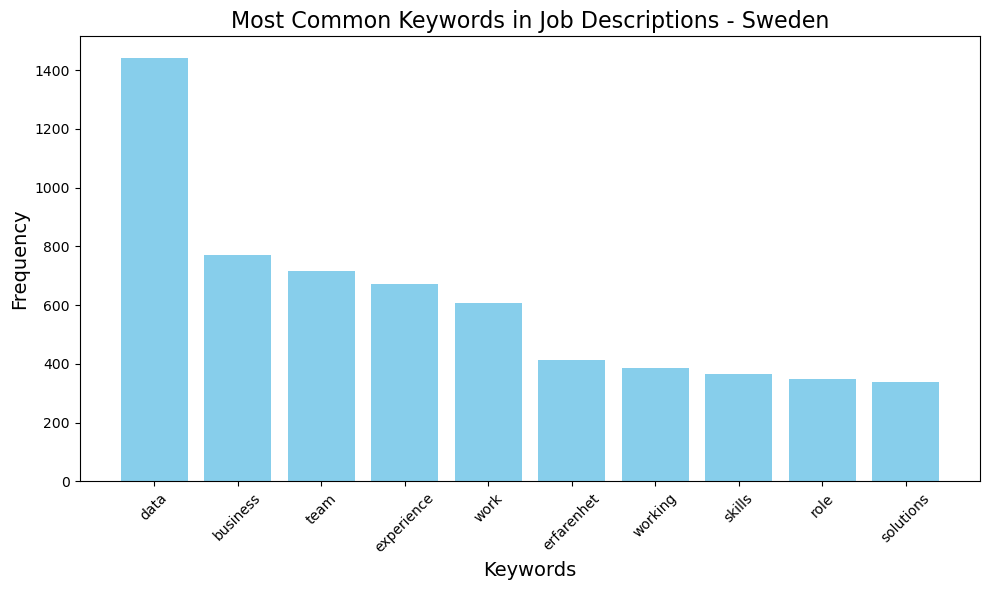

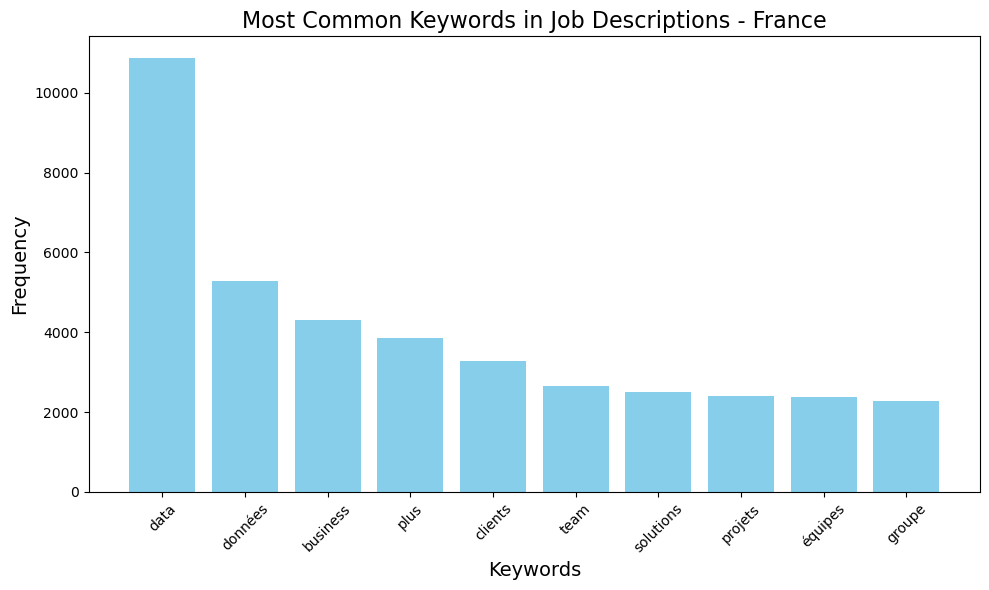

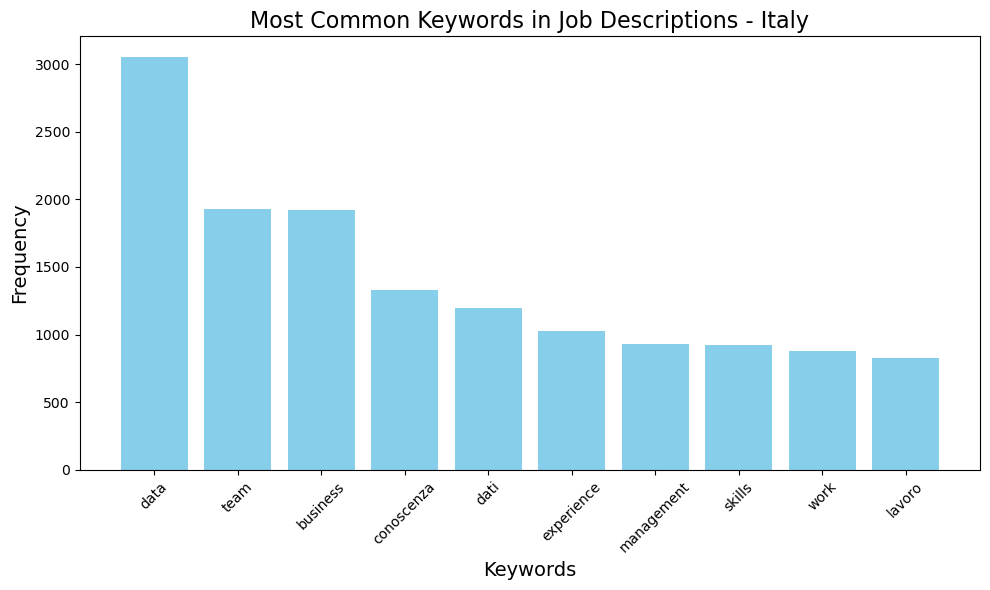

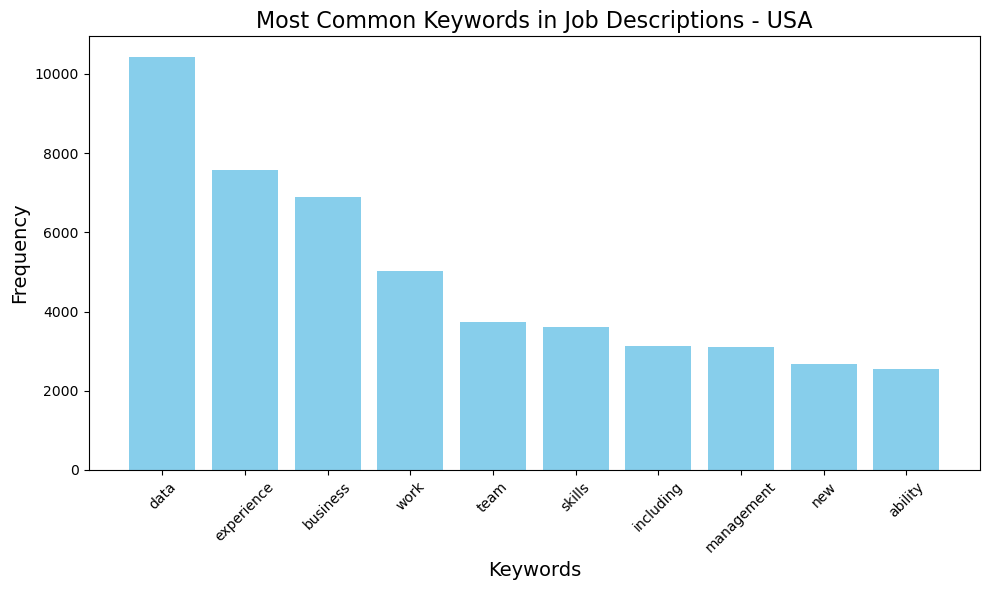

In [40]:
def plot_common_keywords(common_keywords, country):
    """
    Plots the most common keywords from job descriptions.

    Parameters:
    - common_keywords: List of tuples (keyword, frequency).
    - country: Name of the country for labeling the plot.
    """
    # Unzip the list of tuples into two lists: words and counts
    words, counts = zip(*common_keywords)

    # Create a bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(words, counts, color='skyblue')  # Bar plot
    plt.xlabel('Keywords', fontsize=14)  # Label for x-axis
    plt.ylabel('Frequency', fontsize=14)  # Label for y-axis
    plt.title(f'Most Common Keywords in Job Descriptions - {country}', fontsize=16)  # Title of the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to make room for rotated labels
    plt.show()  # Display the plot

common_keywords_SWE = extract_keywords(df_combined, 'Sweden', 'swedish')
common_keywords_FRA = extract_keywords(df_combined, 'France', 'french')
common_keywords_ITA = extract_keywords(df_combined, 'Italy', 'italian')
common_keywords_USA = extract_keywords(df_combined, 'USA', 'english')

plot_common_keywords(common_keywords_SWE[0], 'Sweden')
plot_common_keywords(common_keywords_FRA[0], 'France')
plot_common_keywords(common_keywords_ITA[0], 'Italy')
plot_common_keywords(common_keywords_USA[0], 'USA')

In [ ]:
# To do: Create a df with counts for all keywords, but make sure filtering is possible based on both country and job title that was searched for 

In [64]:
# subdivide this into additional categories: software
software_keywords = {
    'Programming Languages': [
        'python', ' r ', 'javascript', 'java', 'c++', 'c#', 'ruby', 'swift', 'kotlin', 'scala', 'matlab', 'sas', 'stata', ' go ', 'php', 'typescript', 'rust', 'bash'
    ],
    'Data Analysis and Manipulation': [
        'excel', 'pandas', 'numpy', 'dplyr', 'tidyverse', 'julia', 'matlab', 'stata'
    ],
    'Machine Learning and Statistical Modeling': [
        'scikit-learn', 'tensorflow', 'keras', 'pytorch', 'xgboost', 'catboost', 'lightgbm', 'mlpack', 'caret', 'mlr', 'weka', 'statsmodels'
    ],
    'Data Visualization and Business Intelligence (BI) Tools': [
        'tableau', 'power bi', 'matplotlib', 'seaborn', 'd3.js', 'looker', 'plotly', 'ggplot2', 'qlik', 'sap', 'looker studio', 'superset', 'metabase'
    ],
    'Big Data Technologies': [
        'spark', 'hadoop', 'bigquery', 'redshift', 'snowflake', 'databricks', 'hive', 'kafka', 'hdfs', 'flink', 'storm'
    ],
    'Database Management Systems (DBMS)': [
        'mysql', 'postgresql', 'mongodb', 'cassandra', 'oracle', 'microsoft sql server', 'firebase', 'db2', 'couchbase', 'neo4j', 'redis', 'couchdb', 'mariadb'
    ],
    'Cloud Computing': [
        'aws', 'azure', 'google cloud', 'gcp', 'ibm cloud', 'oracle cloud', 'digitalocean', 'heroku'
    ],
    'Development Tools': [
        'git', 'docker', 'vscode', 'jupyter', 'pycharm', 'rstudio', 'eclipse', 'netbeans', 'intellij idea', 'notepad++', 'sublime text', 'atom'
    ],
    'Version Control and Collaboration': [
        'github', 'gitlab', 'bitbucket', 'jira', 'confluence', 'slack', 'trello', 'microsoft teams', 'asana', 'notion'
    ],
    'Containerization and Orchestration': [
        'docker', 'kubernetes', 'openshift', 'mesos', 'rancher', 'nomad'
    ],
    'Workflow Management': [
        'airflow', 'luigi', 'prefect', 'kubeflow'
    ],
    'Data Science Platforms': [
        'databricks', 'knime', 'h2o.ai', 'rapidminer', 'datarobot', 'mlflow'
    ]
}

In [84]:
def count_keywords(df, country):
    """
    Counts the occurrences of keywords in job descriptions by category and sub-category for a specific country,
    creating separate entries for each keyword and its associated search keyword.

    Parameters:
    - df: DataFrame containing job descriptions and search keywords.
    - country: String representing the country to filter by.

    Returns:
    - A DataFrame with categories, sub-categories, keyword counts, associated search keywords, and country.
    """
    # Prepare the DataFrame list to store individual entries
    data = []

    # Filter DataFrame by country
    filtered_df = df[df['country'] == country]
    
    # Flatten the keywords into a single list with their categories
    category_keywords = [(category, keyword) for category, keywords in software_keywords.items() for keyword in keywords]

    for index, row in filtered_df.iterrows():
        job_description = row['job_description'].lower()  # Access job description
        search_keyword = row['search_keyword']  # Access associated search keyword
        
        for category, keyword in category_keywords:
            count = job_description.count(keyword)
            if count > 0:  # Only record non-zero counts
                data.append({
                    'Category': category,
                    'Keyword': keyword,
                    'Count': count,
                    'Search Keyword': search_keyword,
                    'Country': country  
                })

    # Create a df from the collected data
    result_df = pd.DataFrame(data)

    # Group by relevant columns and sum the counts
    result_df = result_df.groupby(['Category', 'Keyword', 'Search Keyword', 'Country'], as_index=False).sum()

    return result_df

# Calculate keyword counts for each country using the new function
keyword_counts_SWE = count_keywords(df_combined, 'Sweden')
keyword_counts_FRA = count_keywords(df_combined, 'France')
keyword_counts_ITA = count_keywords(df_combined, 'Italy')
keyword_counts_USA = count_keywords(df_combined, 'USA')

In [92]:
# Combine all country dfs into one
keyword_counts_combined = pd.concat([keyword_counts_SWE, keyword_counts_FRA, keyword_counts_ITA, keyword_counts_USA], ignore_index=True)

keyword_counts_combined.sort_values(by=['Count'], ascending=[False]).head()

,Category,Keyword,Search Keyword,Country,Count
348,Development Tools,git,Data Analyst,France,862
755,Data Analysis and Manipulation,excel,Data Analyst,USA,765
350,Development Tools,git,Product Analyst,France,704
241,Data Analysis and Manipulation,excel,Product Analyst,France,602
239,Data Analysis and Manipulation,excel,Data Analyst,France,602


In [80]:
# subdivide this into additional categories: skills
# subdivide this into additional categories: interview procedures 

## Univariate analysis 


In [ ]:
# histograms for salaries 
# to do 

## Bivariate analysis 

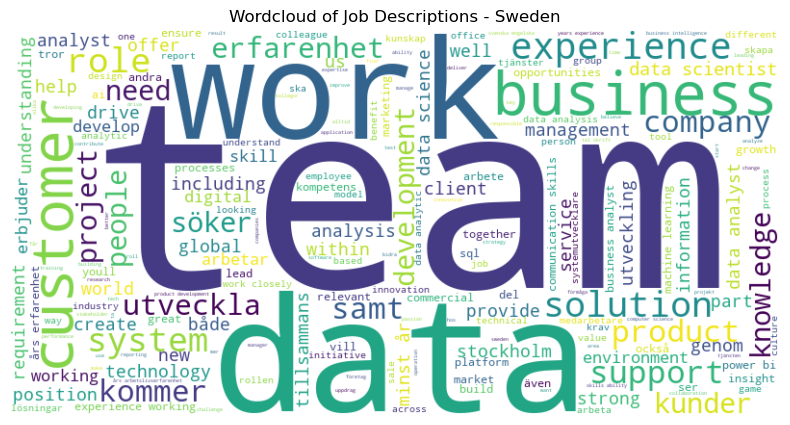

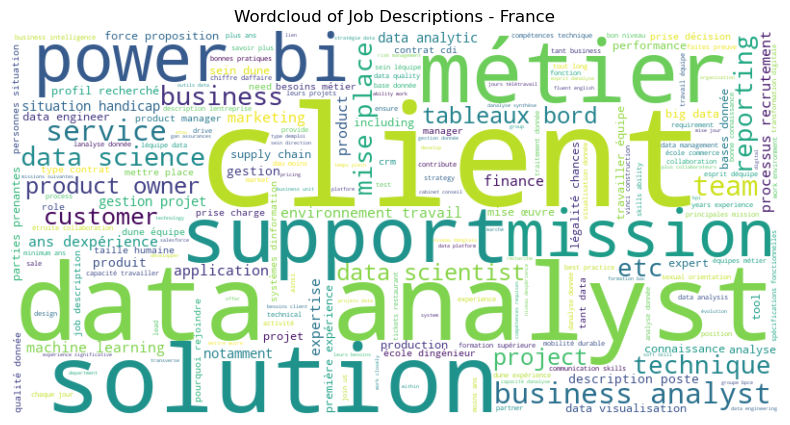

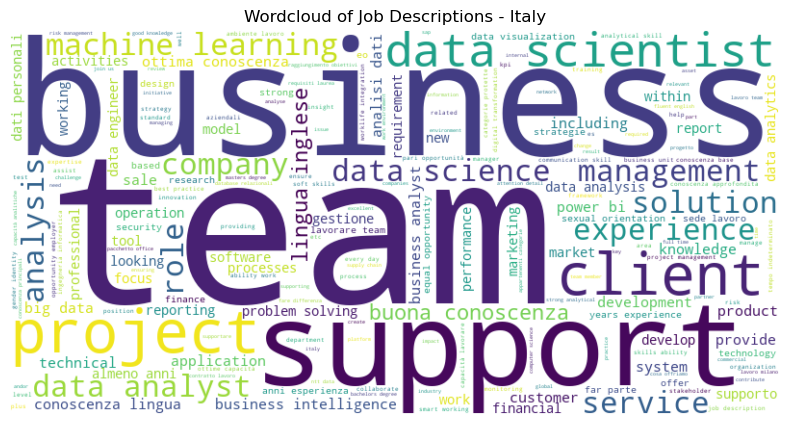

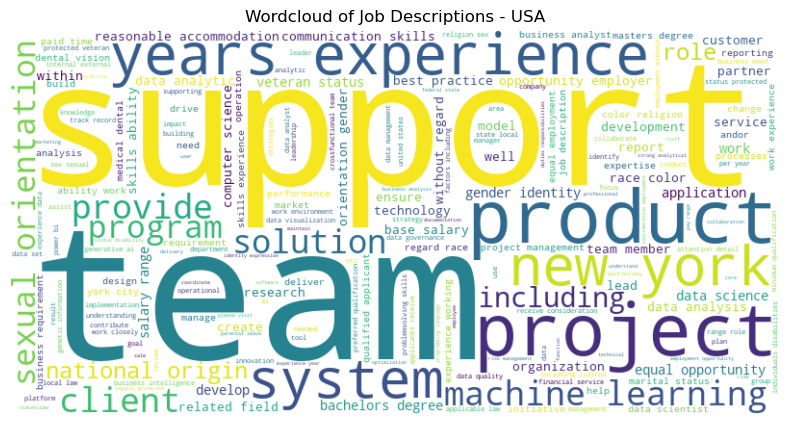

In [78]:
# Word cloud visualizations
def plt_wordtree(data, country):
    #df = data['job_description']
    #country = 'France'
    # Combine all the text into a single string 
    text = ' '.join(data)
    # Create a wordcloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    # Display the wordcloud 
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Wordcloud of Job Descriptions - {country}')
    plt.axis('off')
    plt.show()

plt_wordtree(common_keywords_SWE[1], 'Sweden')
plt_wordtree(common_keywords_FRA[1], 'France')
plt_wordtree(common_keywords_ITA[1], 'Italy')
plt_wordtree(common_keywords_USA[1], 'USA')

In [ ]:
# Box plots help visualize the distribution of salary ranges across different categories (e.g., job titles, countries).
# Look at outliers

# Number of job listings per job title and country 

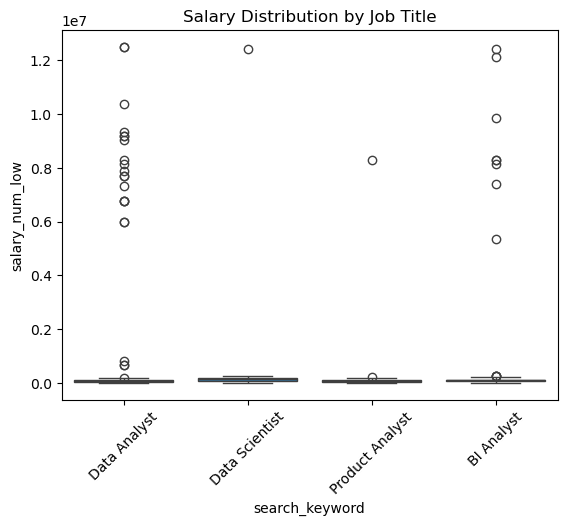

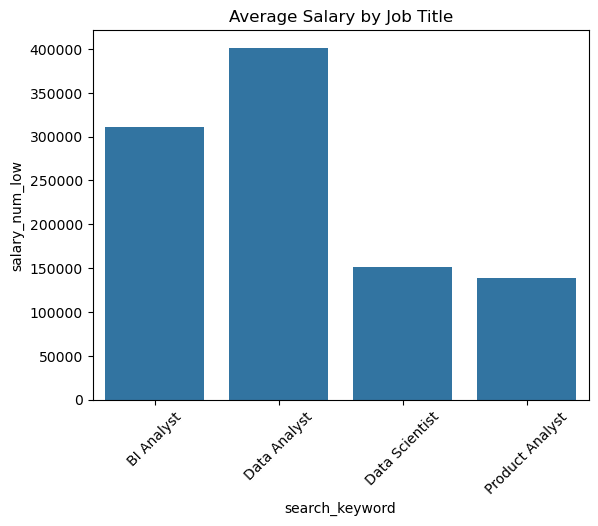

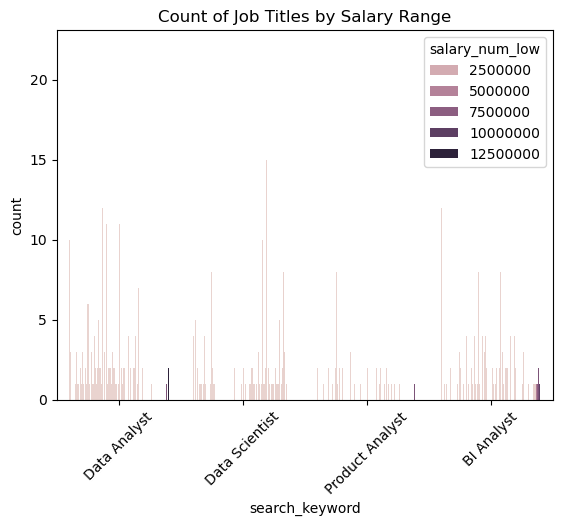

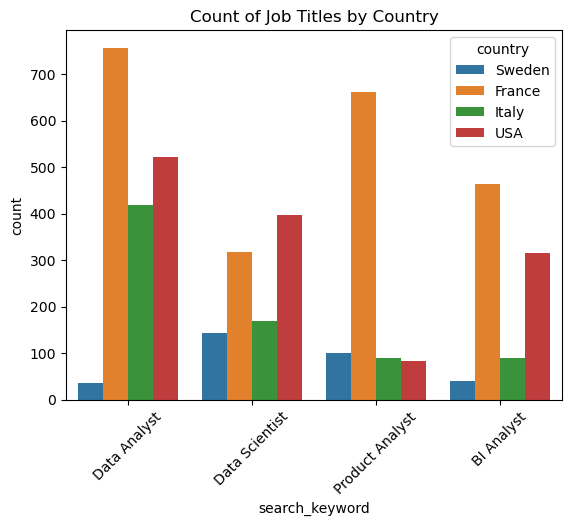

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Please note: salaries are not in the same currency so comparisons cant really be made 

sns.boxplot(data=df_combined, x='search_keyword', y='salary_num_low')
plt.xticks(rotation=45)
plt.title('Salary Distribution by Job Title')
plt.show()

mean_salary = df_combined.groupby('search_keyword')['salary_num_low'].mean().reset_index()
sns.barplot(data=mean_salary, x='search_keyword', y='salary_num_low')
plt.xticks(rotation=45)
plt.title('Average Salary by Job Title')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='salary_num_low')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Salary Range')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='country')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Country')
plt.show()

In [84]:

import scipy.stats as stats

salary_ranges = pd.cut(df_combined['salary_num_low'], bins=[0, 20000, 40000, 60000, 80000, 100000], labels=['<20k', '20-40k', '40-60k', '60-80k', '80-100k'])
crosstab = pd.crosstab(df_combined['search_keyword'], salary_ranges)
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print(f'Chi-squared: {chi2}, p-value: {p}')

Chi-squared: 49.42119385340937, p-value: 1.7651158758369473e-06


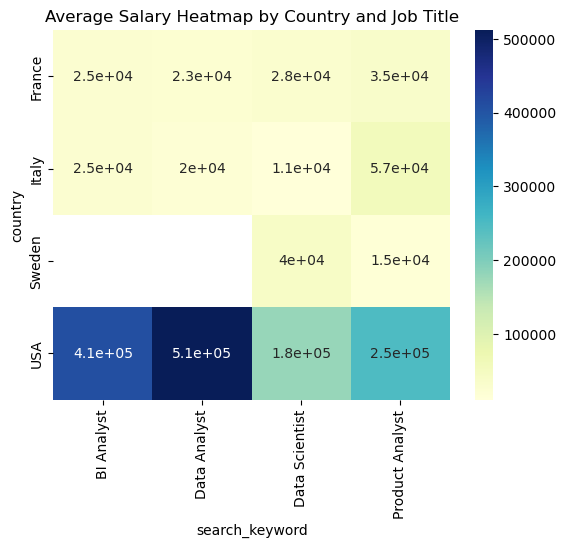

"\ng = sns.FacetGrid(df_clean, col='search_location', col_wrap=3)\ng.map(sns.boxplot, 'search_keyword', 'salary_num_low')\nplt.xticks(rotation=45)\nplt.show()\n"

In [85]:
pivot_table = df_combined.pivot_table(values='salary_num_low', index='country', columns='search_keyword', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Average Salary Heatmap by Country and Job Title')
plt.show()

'''
g = sns.FacetGrid(df_clean, col='search_location', col_wrap=3)
g.map(sns.boxplot, 'search_keyword', 'salary_num_low')
plt.xticks(rotation=45)
plt.show()
'''

## Conclusions 
TBA.
Also interesting to look into 'Recruitment process' and 'Interview' process since there is data about that in the dataset?